### Summary

1.Exploratory Data Analysis on NYC Taxi data <br>
2.Build a machine learning model to predict the duration of NYC taxi trip.

### Introduction

In this notebook, we will first study and visualise the data, engineer new features, and examine potential outliers.<br>
Finally, we will make a brief excursion into viewing this challenge as a classification problem and finish this notebook with a simple Ensemble model that provides a basic prediction.<br>
Dataset downloaded from : https://www.kaggle.com/code/neomatrix369/chaieda-nyc-taxi-trip-duration-analysis/input?select=train_test_extended.csv

### Libraries

In [61]:
#importing the python libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
#from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from geopy.distance import geodesic
import time
from IPython.display import clear_output         
import warnings
warnings.filterwarnings('ignore')
#https://github.com/TanmayKedari/Exploratory-Analysis-of-NYC-Taxi/blob/master/NYC%20Taxi%20Trip%20Duration.ipynb

In [62]:
taxi_data = pd.read_csv('/Users/johnsiraniperiandavar/jupiter_dir/nyc/data/rideshare_data.csv')
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81763 entries, 0 to 81762
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              81763 non-null  int64  
 1   id                      81763 non-null  object 
 2   vendor_id               81763 non-null  int64  
 3   pickup_datetime         81763 non-null  object 
 4   dropoff_datetime        57199 non-null  object 
 5   passenger_count         81763 non-null  int64  
 6   pickup_longitude        81763 non-null  float64
 7   pickup_latitude         81763 non-null  float64
 8   dropoff_longitude       81763 non-null  float64
 9   dropoff_latitude        81763 non-null  float64
 10  store_and_fwd_flag      81763 non-null  object 
 11  trip_duration           57199 non-null  float64
 12  pickup_district         81763 non-null  object 
 13  pickup_neighbourhood    81763 non-null  object 
 14  dropoff_district        81763 non-null

### Explore data

In [63]:
taxi_data.head()

,Unnamed: 0,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,...,dropoff_geonumber,day_period,month,year,season,weekday_or_weekend,regular_day_or_holiday,pickup_hour,day_name,financial_quarter
0,36,id1870624,1,2016-01-05 15:29:54,2016-01-05 15:39:07,3,-73.951515,40.770248,-73.958527,40.761517,...,23463.114456,2. Afternoon,01. Jan,2016,1. Winter,Weekday,Regular day,15,2. Tuesday,4
1,46,id3188770,1,2016-01-03 16:59:02,2016-01-03 17:04:50,1,-73.985138,40.732193,-73.989639,40.720875,...,23455.767822,2. Afternoon,01. Jan,2016,1. Winter,Weekend,Regular day,16,7. Sunday,4
2,56,id1388344,2,2016-01-02 15:41:11,2016-01-02 16:01:39,2,-73.982338,40.762810,-73.982857,40.748779,...,23460.797417,2. Afternoon,01. Jan,2016,1. Winter,Weekend,Regular day,15,6. Saturday,4
3,61,id1040444,2,2016-01-07 17:01:32,2016-01-07 17:13:33,4,-73.976952,40.752022,-74.001213,40.751614,...,23461.289238,2. Afternoon,01. Jan,2016,1. Winter,Weekday,Regular day,17,4. Thursday,4
4,82,id2934884,2,2016-01-07 19:32:15,2016-01-07 19:40:55,1,-73.986389,40.756615,-73.999794,40.761631,...,23463.093788,3. Evening,01. Jan,2016,1. Winter,Weekday,Regular day,19,4. Thursday,4


In [64]:
taxi_data['pickup_datetime'].min()

'2016-01-01 00:00:17'

In [65]:
taxi_data['pickup_datetime'].max()

'2016-01-08 23:59:55'

###### Dataset has the trip data starting from 2016-01-01 to 2016-01-08

###### 1. Check if the dataset has any empty values

In [66]:
taxi_data.isna().sum()

Unnamed: 0                    0
id                            0
vendor_id                     0
pickup_datetime               0
dropoff_datetime          24564
passenger_count               0
pickup_longitude              0
pickup_latitude               0
dropoff_longitude             0
dropoff_latitude              0
store_and_fwd_flag            0
trip_duration             24564
pickup_district               0
pickup_neighbourhood          0
dropoff_district              0
dropoff_neighbourhood         0
pickup_geonumber              0
dropoff_geonumber             0
day_period                    0
month                         0
year                          0
season                        0
weekday_or_weekend            0
regular_day_or_holiday        0
pickup_hour                   0
day_name                      0
financial_quarter             0
dtype: int64

###### Empty values in the dropoff_time shows in the incomplete trips. We can remove these trips to reduce the dataset size.

In [67]:
taxi_data_cleaned = taxi_data.dropna()


###### 2. Lets look at the unique values in the object fields

In [68]:
print('Unique values in the fields')
for col in taxi_data_cleaned.columns:
    if taxi_data_cleaned[col].dtype == object and col not in ['id','pickup_datetime','dropoff_datetime','pickup_neighbourhood','dropoff_neighbourhood']:
        print(col,":",taxi_data_cleaned[col].unique())

Unique values in the fields
store_and_fwd_flag : ['N' 'Y']
pickup_district : ['Brooklyn' 'Manhattan' 'Staten Island' 'Queens' 'Outside NYC']
dropoff_district : ['Manhattan' 'Brooklyn' 'Staten Island' 'Queens' 'Outside NYC']
day_period : ['2. Afternoon' '3. Evening' '1. Morning' '4. Night']
month : ['01. Jan']
season : ['1. Winter']
weekday_or_weekend : ['Weekday' 'Weekend']
regular_day_or_holiday : ['Regular day' 'Holiday (or Festival)']
day_name : ['2. Tuesday' '7. Sunday' '6. Saturday' '4. Thursday' '5. Friday'
 '1. Monday' '3. Wednesday']


In [69]:
print('Unique values in the vendor_id')
taxi_data_cleaned['vendor_id'].unique()

Unique values in the vendor_id


array([1, 2])

###### 3.Convert the pickup_datetime and dropoff_datetime datatype to datetime

In [70]:
taxi_data_cleaned['pickup_datetime'] = pd.to_datetime(taxi_data_cleaned['pickup_datetime'])
taxi_data_cleaned['dropoff_datetime'] = pd.to_datetime(taxi_data_cleaned['dropoff_datetime'])

###### 4.Calculate distance between pickup and dropoff coordinates using geodesic

In [71]:
distance = []
for index in taxi_data_cleaned['pickup_latitude'].index:
    distance.append(geodesic((taxi_data_cleaned['pickup_latitude'].iloc[index],taxi_data_cleaned['pickup_longitude'].iloc[index]),(taxi_data_cleaned['dropoff_latitude'].iloc[index],taxi_data_cleaned['dropoff_longitude'].iloc[index])).miles)
taxi_data_cleaned['distance'] = distance

###### Description on Features 
id - a unique identifier for each trip <br>
vendor_id - business provider id. possible values are 0 or 1 <br>
pickup_datetime - Trip pickup time<br>
dropoff_datetime - Trip end time<br>
passenger_count - Number of passengers in the vehicle<br>
pickup_longitude - Trip start longitude<br>
pickup_latitude - Trip start latitude<br>
dropoff_longitude - Trip end longitude<br>
dropoff_latitude - Trip end latitude<br>
pickup_district - Trip pickup district<br>
dropoff_district - Trip end district<br>
store_and_fwd_flag - possible values y or n<br>
day_period - possible values Afternoon,Night,Morning,Evening <br>
month : Month the trip was taken. Metric from pickup_datetime<br>
season : Season the trip was taken.Metric from pickup_datetime<br>
weekday_or_weekend : Weekday trip or weekend trip<br>
regular_day_or_holiday : Regular day or holiday trip<br>
day_name : day name <br>
pickup_hour: on which hour of the day the trip started <br>
financial_quarter: financial quarter <br>
trip_duration - Trip duration in seconds<br>
distance - Trip distance metric calculated from start lat/long and end lat/long<br>


### Data Analysis

###### Total trips  comparison charts by Vendor Id and Passenger

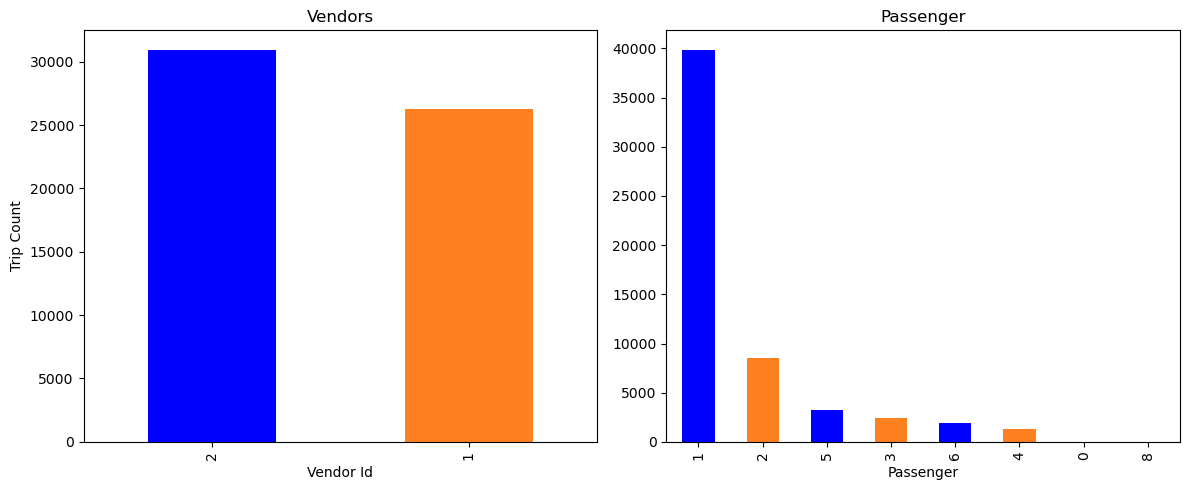

In [72]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12,5))
ax = taxi_data_cleaned['vendor_id'].value_counts().plot(kind='bar',title="Vendors",ax=axes[0],color = ('blue',(1, 0.5, 0.13)))

ax1= taxi_data_cleaned['passenger_count'].value_counts().plot(kind='bar',title="Passenger",ax=axes[1],color = ('blue',(1, 0.5, 0.13)))
ax.set_ylabel("Trip Count")
ax.set_xlabel("Vendor Id")
ax1.set_xlabel("Passenger")
fig.tight_layout()

Each trip has either vendor id 1 or 0 and number of trips taken by vendor 2 is higher than 1 <br>
Most of the taxi's allows 1 to 4 passengers. Some of the big vehicles allow upto 6 passengers.The data looks legitimate.

### Comparing trips with pickup_district and dropoff_district

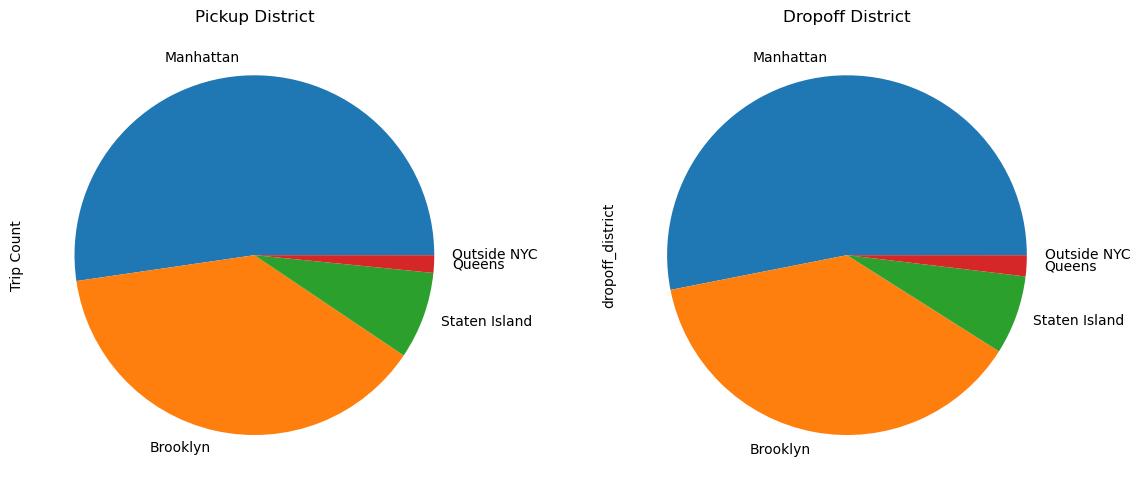

In [73]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12,5))
ax = taxi_data_cleaned['pickup_district'].value_counts().plot(kind='pie',title="Pickup District",ax=axes[0])
ax1= taxi_data_cleaned['dropoff_district'].value_counts().plot(kind='pie',title="Dropoff District",ax=axes[1])
ax.set_ylabel("Trip Count")
fig.tight_layout()

###### Most of the pickup and dropoff are Manhatten and Brooklyn districts. Those 2 districts dominates both the trip pickup and dropoff

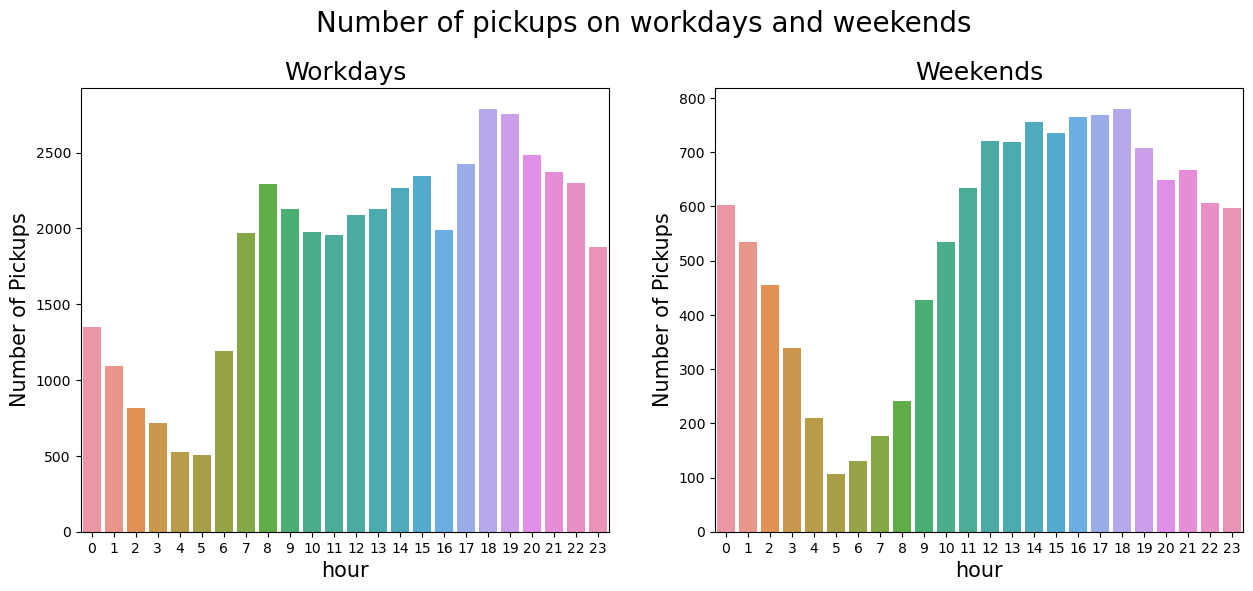

In [74]:
fig, axes = plt.subplots(figsize=(15,6), nrows=1, ncols=2)
workday_trips = taxi_data_cleaned.loc[taxi_data_cleaned['weekday_or_weekend']=='Weekday']
weekend_trips = taxi_data_cleaned.loc[taxi_data_cleaned['weekday_or_weekend']=='Weekend']

sns.countplot(ax=axes[0], x=workday_trips['pickup_hour'])
sns.countplot(ax=axes[1], x=weekend_trips['pickup_hour'])

axes[0].set_title('Workdays',fontsize = 18)
axes[0].set_xlabel('hour', fontsize=15)
axes[0].set_ylabel('Number of Pickups', fontsize=15)
axes[1].set_title('Weekends',fontsize = 18)
axes[1].set_xlabel('hour', fontsize=15)
axes[1].set_ylabel('Number of Pickups', fontsize=15)

fig.suptitle('Number of pickups on workdays and weekends',fontsize = 20)
plt.subplots_adjust(top = 0.85)
plt.show;

We can confirm from the charts above that people use taxi during the weekend more than weekdays.<br>
The trend shows midnight pickups are high during weekends than weekdays.

###### Trip vs Neighborhood Analysis

Lets create 2 new features in the dataset by adding neighborhood and district together.

In [75]:
taxi_data_cleaned['pickup_dist_neigh'] = taxi_data_cleaned['pickup_neighbourhood']+','+ taxi_data_cleaned['pickup_district']
taxi_data_cleaned['dropoff_dist_neigh'] = taxi_data_cleaned['dropoff_neighbourhood']+','+ taxi_data_cleaned['dropoff_district']

In [76]:
pickup_most = taxi_data_cleaned['pickup_dist_neigh'].value_counts(sort=True).nlargest(10)
dropoff_most = taxi_data_cleaned['dropoff_dist_neigh'].value_counts(sort=True).nlargest(10)
print('Top 10 Most Pickup Neighborhoods')
display(pickup_most)
print('Top 10 Most Dropoff Neighborhoods')
display(dropoff_most)

Top 10 Most Pickup Neighborhoods


Upper West Side,Manhattan      7163
Harlem,Manhattan               6297
East Harlem,Manhattan          6104
Bedford-Stuyvesant,Brooklyn    5445
South Slope,Brooklyn           2759
Hell's Kitchen,Manhattan       2207
West Village,Manhattan         2042
Clinton Hill,Brooklyn          1809
Williamsburg,Brooklyn          1780
Fort Greene,Brooklyn           1773
Name: pickup_dist_neigh, dtype: int64

Top 10 Most Dropoff Neighborhoods


Upper West Side,Manhattan      7059
Harlem,Manhattan               6660
East Harlem,Manhattan          6306
Bedford-Stuyvesant,Brooklyn    5036
South Slope,Brooklyn           2612
Hell's Kitchen,Manhattan       2226
Kensington,Brooklyn            2106
West Village,Manhattan         1945
Clinton Hill,Brooklyn          1915
Midtown,Manhattan              1684
Name: dropoff_dist_neigh, dtype: int64

In [77]:
pickup_least = taxi_data_cleaned['pickup_dist_neigh'].value_counts(sort=True).nsmallest(10)
dropoff_least = taxi_data_cleaned['dropoff_dist_neigh'].value_counts(sort=True).nsmallest(10)
print('Top 10 Least Pickup Neighborhoods')
display(pickup_least)
print('Top 10 Least Dropoff Neighborhoods')
display(dropoff_least)

Top 10 Least Pickup Neighborhoods


Financial District,Manhattan    1
New Dorp,Staten Island          1
Ridgewood,Queens                1
Fort Wadsworth,Staten Island    1
Outside NYC,Outside NYC         1
Willowbrook,Staten Island       3
Sunset Park,Brooklyn            3
Breezy Point,Queens             4
Dongan Hills,Staten Island      4
Sea Gate,Brooklyn               4
Name: pickup_dist_neigh, dtype: int64

Top 10 Least Dropoff Neighborhoods


Brownsville,Brooklyn             1
Prospect Heights,Brooklyn        1
Outside NYC,Outside NYC          1
Fort Wadsworth,Staten Island     1
SoHo,Manhattan                   2
Sunset Park,Brooklyn             2
Lighthouse Hill,Staten Island    2
New Dorp,Staten Island           2
St. George,Staten Island         3
Howland Hook,Staten Island       3
Name: dropoff_dist_neigh, dtype: int64

###### Trip distance Vs Trip Duration

<Axes: xlabel='distance', ylabel='trip_duration'>

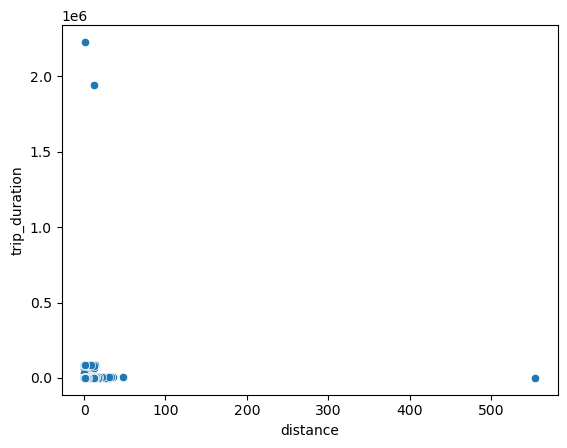

In [78]:
sns.scatterplot(data=taxi_data_cleaned, x="distance", y="trip_duration")

The plot shows some outliers in the distance and trip_duration field

In [79]:
print(taxi_data_cleaned['trip_duration'].min())
print(taxi_data_cleaned['trip_duration'].max())
print(taxi_data_cleaned['trip_duration'].mean())
taxi_data_cleaned[taxi_data_cleaned['trip_duration']>5000].shape[0]

1.0
2227612.0
941.6869176034546


113

In [80]:
print(taxi_data_cleaned['distance'].min())
print(taxi_data_cleaned['distance'].max())
print(taxi_data_cleaned['distance'].mean())
taxi_data_cleaned[taxi_data_cleaned['distance']>30].shape[0]

0.0
554.0541843362436
2.164837098775131


7

Remove trips with trip_duration over 1000 and distance over 10 miles

In [81]:
taxi_data_cleaned = taxi_data_cleaned[(taxi_data_cleaned['distance']<10) & (taxi_data_cleaned['trip_duration']<1000)]

In [82]:
taxi_data_cleaned.shape[0]

44161

Chart after removing outliers in distance and trip_duration


<Axes: xlabel='distance', ylabel='trip_duration'>

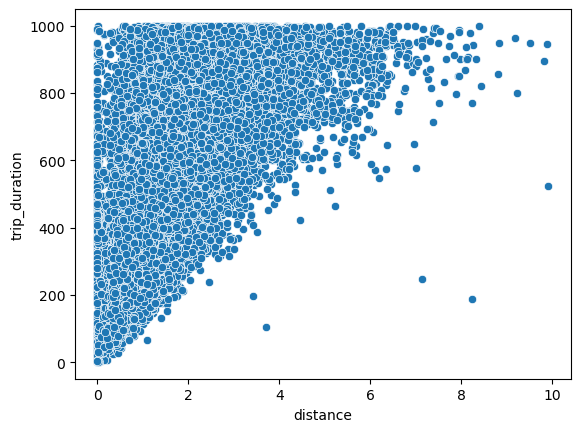

In [83]:
sns.scatterplot(data=taxi_data_cleaned, x="distance", y="trip_duration")

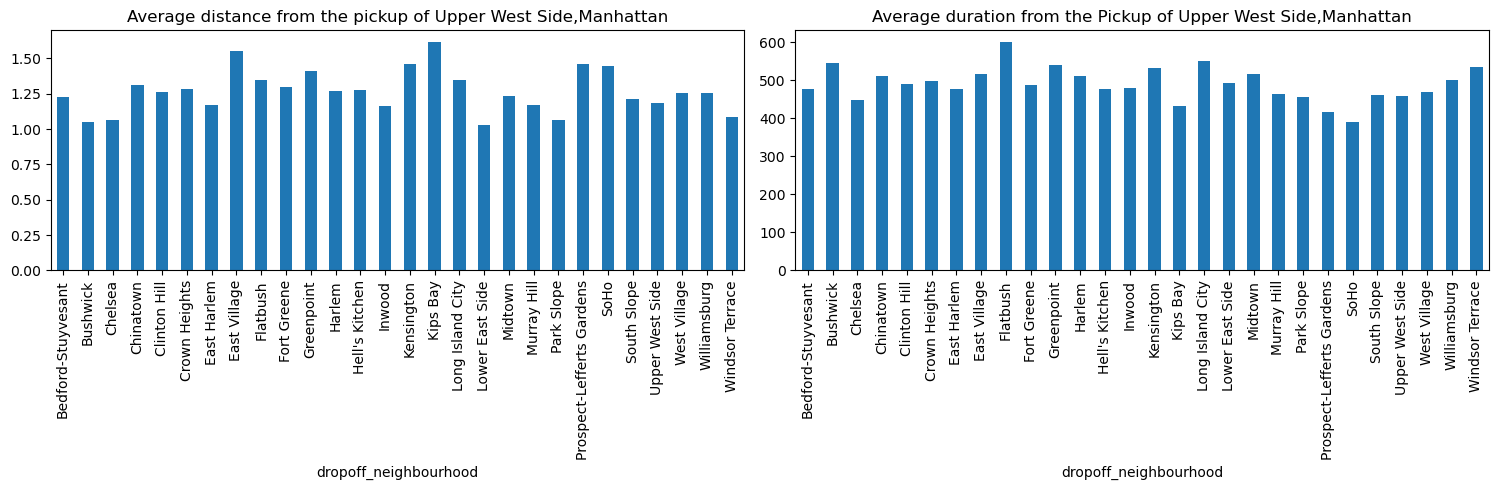

In [84]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
grp_by_pickup = taxi_data_cleaned[taxi_data_cleaned['pickup_dist_neigh']=='Upper West Side,Manhattan']\
                .groupby('dropoff_neighbourhood')['distance'].mean().plot(kind='bar',\
                title="Average distance from the pickup of Upper West Side,Manhattan",ax=axes[0])
grp_by_pickup = taxi_data_cleaned[taxi_data_cleaned['pickup_dist_neigh']=='Upper West Side,Manhattan']\
                .groupby('dropoff_neighbourhood')['trip_duration'].mean().plot(kind='bar',\
                title="Average duration from the Pickup of Upper West Side,Manhattan",ax=axes[1])
ax.set_ylabel("Trip Distance in miles")
ax.set_xlabel("DropOff Neighborhood")
ax1.set_xlabel("DropOff Neighborhood")
ax1.set_ylabel("Trip duration in seconds")
fig.tight_layout()


The trip distance of SoHo looks almost 1.4 miles and Prospect-Lefferts Gardens almost 1.3miles. But the trip duration for Soho is shorter than Prospect-Lefferts Gardens which could be the traffic zone.

###### Lets use labelencoder() to convert the categorical data into numerical field

In [85]:
for col in taxi_data_cleaned.columns:
    if taxi_data_cleaned[col].dtype == object and col not in ['id','pickup_datetime','dropoff_datetime','pickup_neighbourhood','dropoff_neighbourhood']:
     
        taxi_data_cleaned[col] = LabelEncoder().fit_transform(taxi_data_cleaned[col])


In [86]:
i = 0
for col in taxi_data_cleaned.columns:
    print(i,col)
    i+=1

0 Unnamed: 0
1 id
2 vendor_id
3 pickup_datetime
4 dropoff_datetime
5 passenger_count
6 pickup_longitude
7 pickup_latitude
8 dropoff_longitude
9 dropoff_latitude
10 store_and_fwd_flag
11 trip_duration
12 pickup_district
13 pickup_neighbourhood
14 dropoff_district
15 dropoff_neighbourhood
16 pickup_geonumber
17 dropoff_geonumber
18 day_period
19 month
20 year
21 season
22 weekday_or_weekend
23 regular_day_or_holiday
24 pickup_hour
25 day_name
26 financial_quarter
27 distance
28 pickup_dist_neigh
29 dropoff_dist_neigh


###### Correlation Matrix

In [87]:
x = taxi_data_cleaned.iloc[:, [1, 4,9,10, 11,15,16,17,18,20,21,22,23,24,25,26]].values
y = taxi_data_cleaned.iloc[:,10].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state = 7294)

In [88]:
from scipy.stats import pearsonr
df1 = pd.DataFrame(np.concatenate((x_train,y_train.reshape(len(y_train),1)),axis=1))
df1.columns = df1.columns.astype(str)

features = df1.iloc[:,:10].columns.tolist()
target = df1.iloc[:,10].name

correlations = {}
for f in features:
    data_temp = df1[[f,target]]
    x1 = data_temp[f].values
    x2 = data_temp[target].values
    key = f + ' vs ' + 'trip_duration'
    correlations[key] = pearsonr(x1,x2)[0]
    
data_correlations = pd.DataFrame(correlations, index=['Value']).T
data_correlations.loc[data_correlations['Value'].abs().sort_values(ascending=False).index]

,Value
0 vs trip_duration,NaN
1 vs trip_duration,NaN
2 vs trip_duration,NaN
3 vs trip_duration,NaN
4 vs trip_duration,NaN
5 vs trip_duration,NaN
6 vs trip_duration,NaN
7 vs trip_duration,NaN
8 vs trip_duration,NaN
9 vs trip_duration,NaN
